## THIAW Mouhamadou Lamine Bara

#                 Computer Problem Set 2.1 
# The Black-Scholes hedging strategy

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as scpnorm

In [305]:
def brownian_motion(n,T):
    delta_T=T/n
    Zi=np.sqrt(delta_T)*np.random.randn(n)
    brownian=np.zeros(n+1,)
    brownian[1:]=np.cumsum(Zi)
    return brownian

In [306]:
def discrete_path_St(n,T,sigma,mu,So):
    W=brownian_motion(n,T)
    interval=np.linspace(0,T,n+1)
    St=So*np.exp((mu-0.5*sigma**2)*interval +sigma*W)
    return St

In [307]:
T=1
number_of_samples=1000
So=100
n=300
sigma=0.3
r=0.05
t_values=np.linspace(0,T,n+1)
mu_values=[0.02,0.05,0.45]


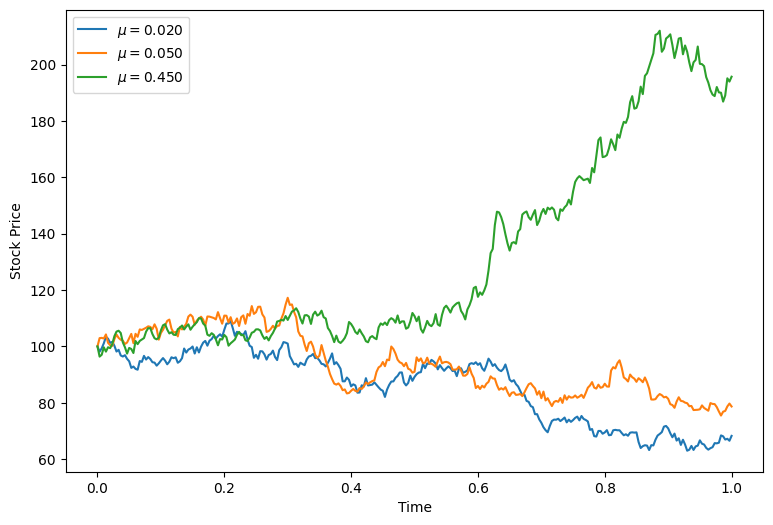

In [308]:
samples=[]
fig,ax=plt.subplots(1,1,figsize=(9,6))
for mu in mu_values:
    samples.append([discrete_path_St(n,T,sigma,mu,So) for sample in range(number_of_samples)])
    ax.plot(t_values,samples[-1][0],label=r"$\mu=%.3f$"%mu)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
plt.show()

Let's compute corresponding mean and variance

In [309]:
samples=np.array(samples)

In [310]:
for idx, drift_rate in enumerate(mu_values):
    print(f"Pour la valeur de dérive {idx + 1}: mu= {drift_rate:.3f}")
    sample_mean = np.mean(samples[idx, :, -1])
    sample_variance = np.var(samples[idx, :, -1], ddof=1)
    print(f"Moyenne de l'échantillon S_T : {sample_mean:.4f}")
    print(f"Variance de l'échantillon S_T : {sample_variance:.4f}")
    print("------------------------------------")


Pour la valeur de dérive 1: mu= 0.020
Moyenne de l'échantillon S_T : 102.4671
Variance de l'échantillon S_T : 1037.7719
------------------------------------
Pour la valeur de dérive 2: mu= 0.050
Moyenne de l'échantillon S_T : 104.9657
Variance de l'échantillon S_T : 1057.8671
------------------------------------
Pour la valeur de dérive 3: mu= 0.450
Moyenne de l'échantillon S_T : 158.6726
Variance de l'échantillon S_T : 2452.2532
------------------------------------


Commentaires: Plus la valeur de $\mu$ augmente, plus la moyenne de l'échantillon St et sa variance augmentent.

Essayons de vérifier celà analytiquement;
En effet:
$$\begin{align*}
    
    \mathrm{Var}\left(S_T\right) &= \exp((2\mu-\sigma^2)T)\mathrm{Var}\left(\exp(\sigma W_T)\right)
\end{align*}
$$

et d'autres part
$$\begin{align*}
    \mathbb E[S_T] &= \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)T\right)\mathbb E\left[\exp(\sigma W_T) \right] \\
    
\end{align*}
$$
Ces deux exprrssions croissent en $exp(\mu)$ 

Question 2

In [311]:
def d_plus(s,k,v):
    return np.log(s/k)/np.sqrt(v) +0.5*np.sqrt(v)

def d_moins(s,k,v):
    return np.log(s/k)/np.sqrt(v) -0.5*np.sqrt(v)

def BS(So,K,T,sigma,r):
    s=So
    k=K*np.exp(-r*T)
    v=T*(sigma**2)
    return s*scpnorm.cdf(d_plus(s,k,v)) - k*scpnorm.cdf(d_moins(s,k,v))

def delta(St,K,T,t,sigma,r=0.05):
    in_the_norm=d_plus(St,K*np.exp(-r*(T-t)),(T-t)*(sigma**2))
    return scpnorm.cdf(in_the_norm)

def xtn(n,T,K,S, mu, sigma, r=0.05):
    bs=BS(S,K,T,sigma,r)
    t_values=np.linspace(0,T,n+1)
    t_values_to_take=t_values[:-1]
    t_values=t_values[1:]
    deltas=delta(S,K,T,t_values_to_take,sigma,r=0.05)
    St = discrete_path_St(n, T, mu, sigma, S)
    St_firsts=St[:-1]
    St=St[1:]
    xt=np.sum(deltas*(np.exp(-r*t_values)*St-np.exp(-r*t_values_to_take)*St_firsts),axis=0)
    xt+=bs
    xt*=np.exp(r*T)
    return xt


In [312]:

number_of_samples=1000
So=100
n=300
sigma=0.3

t_values=np.linspace(0,T,n+1)
mu_values=[0.02,0.05,0.45]
K_values = list(range(80,121))

In [313]:
samples=[]
for K in K_values:
    #print("Pour la valeur de K=%.2f"%K)
    K_samples=[]
    for mu in mu_values:
        K_samples.append([xtn(n,T,K,So,mu,sigma,r=0.05) for i in range(number_of_samples)])
    samples.append(K_samples)    

In [314]:
samples=np.array(samples)



In [315]:
all_means=samples.mean(axis=2)


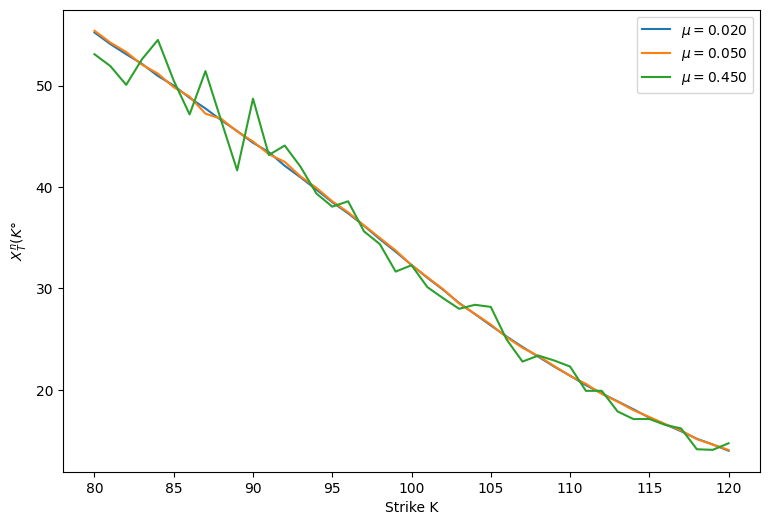

In [316]:
fig,ax=plt.subplots(1,1,figsize=(9,6))
for idx, drift_rate in enumerate(mu_values):
    ax.plot(K_values,all_means[:,idx],label=r"$\mu=%.3f$"%drift_rate)
ax.legend()
ax.set_xlabel('Strike K')
ax.set_ylabel('$X_T^n(K°$')
plt.show()

# Computing profit and loss

In [317]:
def profit_and_loss(n,T,K,S0, mu, sigma, r=0.05):
    bs=BS(S0,K,T,sigma,r)
    t_values=np.linspace(0,T,n+1)
    t_values_to_take=t_values[:-1]
    t_values=t_values[1:]
    deltas=delta(S0,K,T,t_values_to_take,sigma,r=0.05)
    St = discrete_path_St(n, T, mu, sigma, S0)
    S_T=St[-1]
    St_firsts=St[:-1]
    St=St[1:]
    xt=np.sum(deltas*(np.exp(-r*t_values)*St-np.exp(-r*t_values_to_take)*St_firsts),axis=0)
    xt+=bs
    xt*=np.exp(r*T)
    pl=xt-max(0,S_T-K)
    return xt   
    

In [318]:
n_values=[2**8,2**9,2**10,2**11]
number_of_samples=1000

In [319]:
profit_loss_sample=[]
for n in n_values:
    n_sample=[]
    for K in K_values:
        #print("  pour la valeur K=%.3f" % K, end='')
        K_samples=[]
        for mu in mu_values:
             K_samples.append([profit_and_loss(n,T,K,So,mu,sigma,r=0.05) for i in range(number_of_samples)])
        n_sample.append(K_samples)
    profit_loss_sample.append(n_sample)    

In [320]:
profit_loss_sample=np.array(profit_loss_sample)


In [321]:
mean_matrix_profit_loss_sample = np.mean(profit_loss_sample, axis=-1)
var_matrix_profit_loss_sample = np.var(profit_loss_sample, axis=-1, ddof=1)


(c)For each value of μ and K, compute the sample mean and variance of
$PL_T^n(K)$, and provide the corresponding plots in terms of the number
of steps n and the strike K. Comment the results for different sample
sizes.

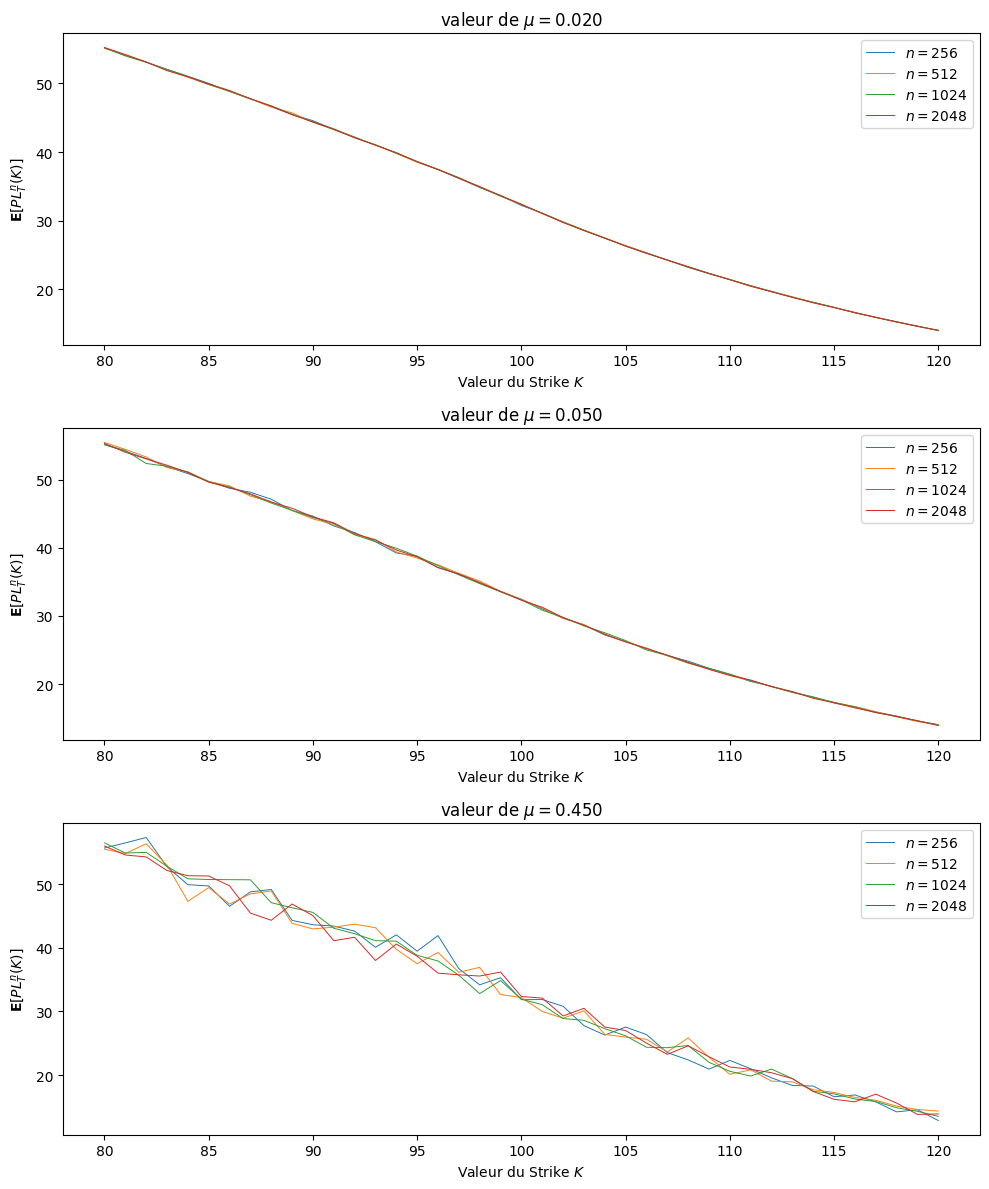

In [322]:
# Create a 3x1 grid of subplots with a specified figure size and DPI
fig, axes = plt.subplots(3, 1, figsize=(10, 12), dpi=100)

# Loop through values of mu and enumerate them
for i, mu in enumerate(mu_values):
    # Loop through values of n and enumerate them
    for j, n in enumerate(n_values):
        # Plot the data with dashed lines, adding labels and customizing line width
        axes[i].plot(K_values, mean_matrix_profit_loss_sample[j,:,i], label=f"$n={n}$", linewidth=0.7)
    
    # Set the x-axis label, legend, title, and y-axis label for the subplot
    axes[i].set_xlabel("Valeur du Strike $K$")
    axes[i].legend()
    axes[i].set_title(f"valeur de $\mu={mu:.3f}$")
    axes[i].set_ylabel(r"$\mathbf{E}[PL_T^n(K)]$")

# Ensure tight layout for better visualization
fig.tight_layout()


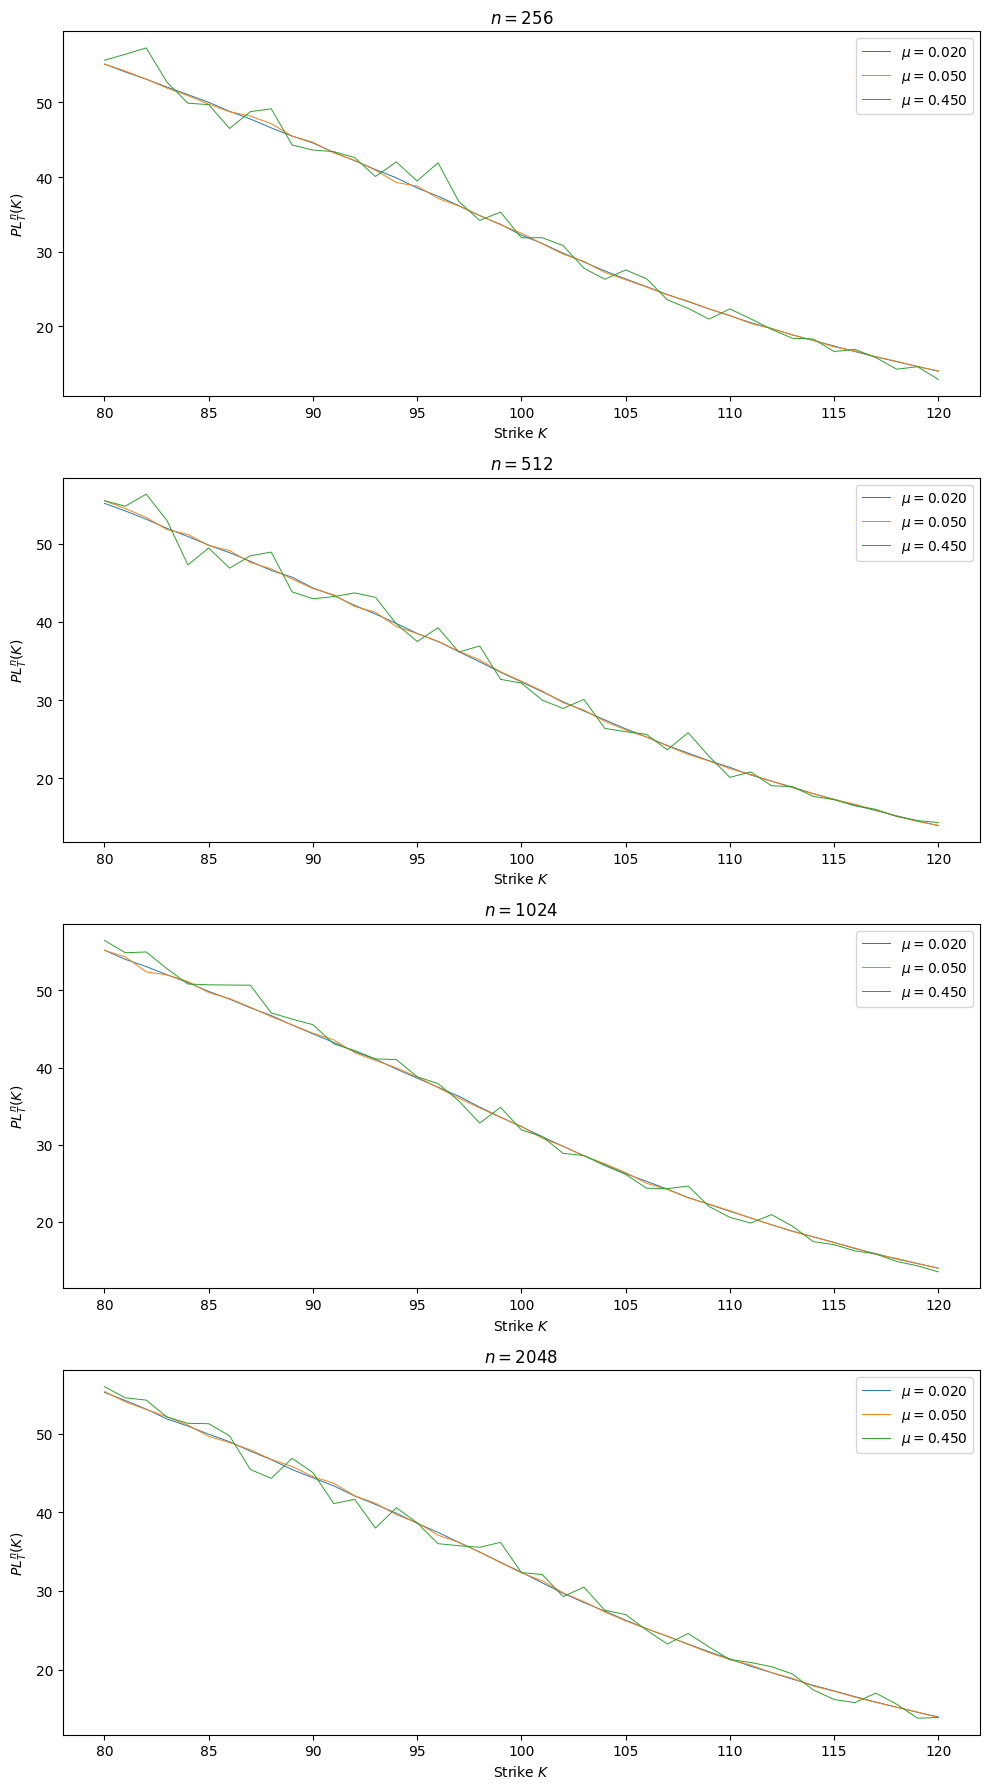

In [323]:
fig, axes = plt.subplots(len(n_values),1,figsize=(10,18),dpi=100)

for i, n in enumerate(n_values):
    for j, mu in enumerate(mu_values):
        axes[i].plot(
            K_values, mean_matrix_profit_loss_sample[i,:,j],
             label=r"$\mu=%.3f$" % mu, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$n=%d$" % n)
    axes[i].set_ylabel("$PL_T^n(K)$")
fig.tight_layout()

Computing the variance

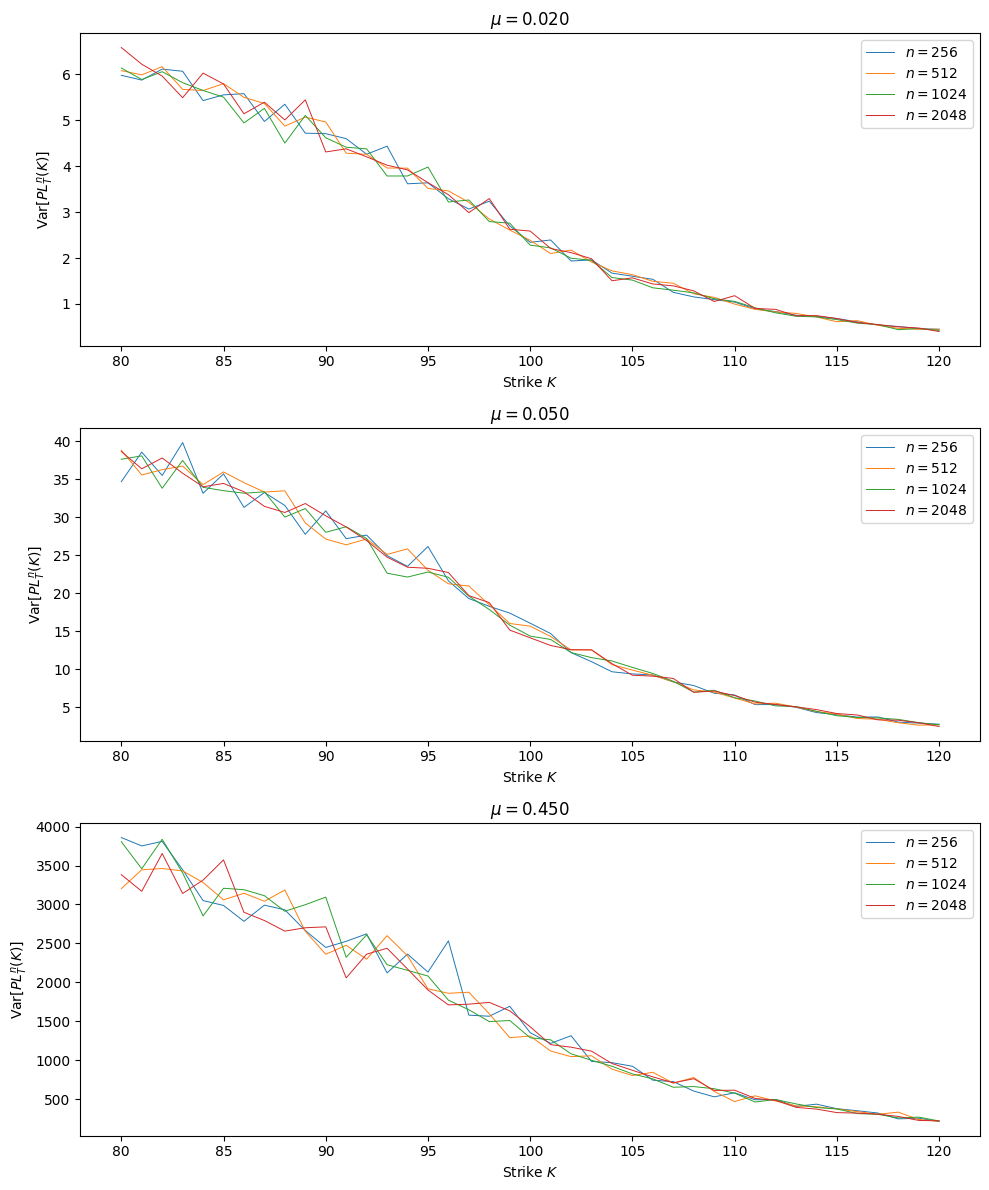

In [326]:
fig, axes = plt.subplots(3,1,figsize=(10,12),dpi=100)

for i, mu in enumerate(mu_values):
    for p, n in enumerate(n_values):
        axes[i].plot(
            K_values, var_matrix_profit_loss_sample[p,:,i],
             label=r"$n=%d$" % n, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathrm{Var}[PL_T^n(K)]$")
fig.tight_layout()